# Customer Propensity Modelling - Grid Search

---

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)
sns.set_style('whitegrid')


Loading the data from the training sample

In [2]:
rawdata = pd.read_csv("../data/raw/training_sample.csv")
rawdata.drop('UserID', axis='columns', inplace=True)


In [3]:
TARGET = 'ordered'

Make a Train/Test split and remember that we need to stratify respect to the `TARGET` because of the imbalance.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    rawdata.drop(TARGET, axis='columns'),
    rawdata[TARGET],
    test_size=0.2, 
    random_state=42,
    shuffle=True,
    stratify=rawdata[TARGET])


In [5]:
from sklearn.metrics import classification_report, confusion_matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.5s finished


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     87262
           1       0.85      0.99      0.91      3819

    accuracy                           0.99     91081
   macro avg       0.92      0.99      0.95     91081
weighted avg       0.99      0.99      0.99     91081



[[Text(0, 0.5, 'No Order'), Text(0, 1.5, 'Order')],
 Text(11.5, 0.5, 'True'),
 [Text(0.5, 0, 'No Order'), Text(1.5, 0, 'Order')],
 Text(0.5, 11.5, 'Predicted'),
 Text(0.5, 1.0, 'Logistic Regression')]

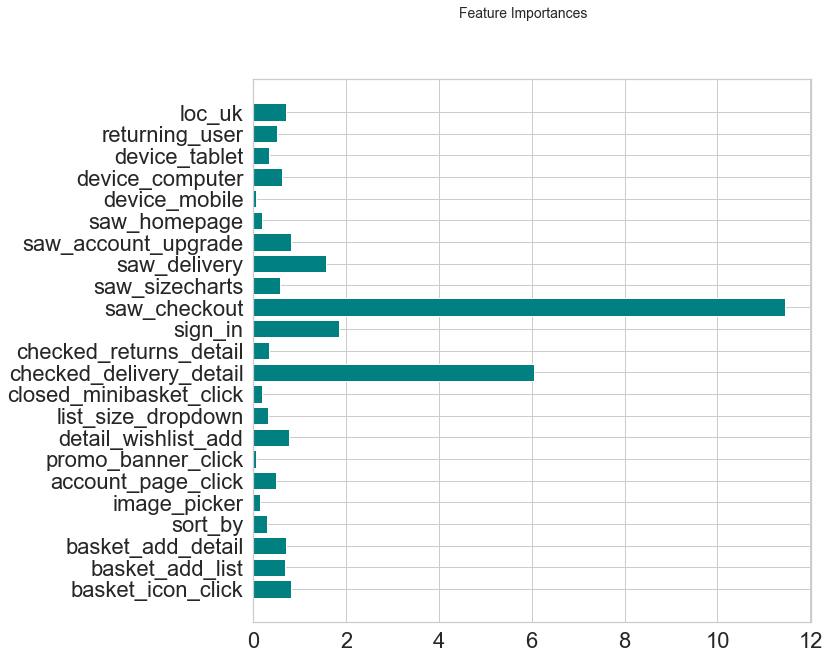

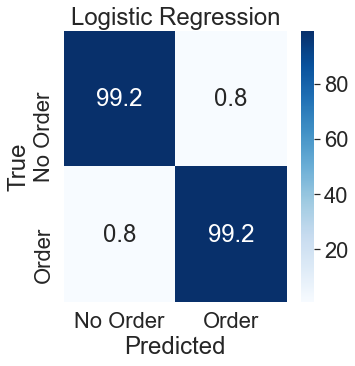

In [6]:
from sklearn.linear_model import LogisticRegression
Logistic = LogisticRegression(
    random_state=42, verbose=True, class_weight='balanced', penalty='l2', C=1,n_jobs=-1)
Logistic.fit(X_train, y_train)
y_predict = Logistic.predict(X_test)

fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(X_test.columns,
        abs(Logistic.coef_[0]),
        color='teal')
fig.suptitle('Feature Importances', size=14)
ax.tick_params(axis='x', labelrotation=0)

print(classification_report(y_test, y_predict))
conf_ma = confusion_matrix(y_test, y_predict, normalize='true')
conf_ma = (100*conf_ma).round(1)
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(conf_ma, annot=True, fmt="1", cmap='Blues', ax=ax)
ax.set(title="Logistic Regression", ylabel="True", xlabel="Predicted",
       xticklabels=('No Order', 'Order'), yticklabels=('No Order', 'Order'))


In [25]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import numpy as np
# define model
model = LogisticRegression(random_state=42)
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# define search space
space = {"C": np.logspace(-3, 3, 5), "penalty": ["l1", "l2"],"class_weight":["balanced","none"]}
# define search
search = GridSearchCV(
    model, space, scoring='f1', n_jobs=-1, cv=cv)
# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


/home/pdona/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
300 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/home/pdona/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/pdona/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/pdona/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 447, in _check_solver
    rai

Best Score: 0.9230260448387753
Best Hyperparameters: {'C': 1.0, 'class_weight': 'none', 'penalty': 'l2'}


In [27]:
suggestion = pd.read_csv("../data/raw/testing_sample.csv")


In [29]:
y_suggestion = Logistic.predict_proba(suggestion.drop(['UserID','ordered'],axis='columns'))


In [35]:
suggestion['order_prob']=y_suggestion.T[1]


In [46]:
suggestion[suggestion['order_prob']>0.8].sort_values(
    by='order_prob', ascending=False)


,UserID,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,...,saw_delivery,saw_account_upgrade,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered,order_prob
61686,62d7-k40b-86b462d7-k40b-4d79-325833,1,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,0.999691
9807,d7d3-7k0b-77b3d7d3-7k0b-4d7j-277864,1,1,1,0,1,0,0,0,0,...,0,0,1,0,1,0,1,1,0,0.999167
19282,7d4k-5058-46bk7d4k-5058-4j5b-892506,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0.999152
52271,kd4d-437d-j4dbkd4d-437d-4k64-689351,1,1,1,0,0,0,1,0,0,...,0,0,1,0,0,1,1,1,0,0.998886
137633,bdd9-90d6-2057bdd9-90d6-41d4-141303,1,1,1,0,1,0,0,0,1,...,0,0,0,0,1,0,1,1,0,0.998859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19365,102k-5b50-46d7102k-5b50-4694-87149,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0.853331
21725,7770-0d42-kdd77770-0d42-44b2-263275,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,1,0,0,0.852072
70897,k30d-483j-95d8k30d-483j-4719-410389,0,0,1,1,0,0,0,0,0,...,1,1,1,0,0,1,1,0,0,0.850441
25368,1830-44dj-d3871830-44dj-4016-612340,0,0,0,0,0,0,1,0,0,...,1,1,1,1,0,0,1,1,0,0.828358
